# 基于Keras的神经网络及其在财务舞弊、图像识别中的应用

## 配置安装

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
from sklearn.linear_model import Perceptron
import pandas as pd
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from tensorflow import keras
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("保存图片", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# 感知机算法-Perceptrons

**Note**: we set `max_iter` and `tol` explicitly to avoid warnings about the fact that their default value will change in future versions of Scikit-Learn.

In [2]:
fraud_detection_samples=pd.read_csv("data/fraud_detection_samples.csv",dtype={"股票代码":str})
fraud_detection_samples=fraud_detection_samples.iloc[:,:-3]

fraud_detection_samples=fraud_detection_samples.fillna(0)
fraud_detection_samples[['流动比率','财务杠杆']].describe()

,流动比率,财务杠杆
count,10641.000000,10641.000000
mean,2.636698,1.550320
std,3.966642,2.439470
min,0.000000,-6.477321
25%,1.151682,0.980168
50%,1.686547,1.072271
75%,2.777394,1.381521
max,190.869175,79.086559


In [3]:
X = np.array(fraud_detection_samples[['流动比率','财务杠杆']])
y = np.array(fraud_detection_samples["是否违规"])
per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

Perceptron(random_state=42)

In [4]:
per_clf.coef_

array([[-5.959342,  4.113779]])

In [5]:
per_clf.score(X,y)

0.6229677661873884

In [6]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 10, -2,8]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

保存图片 perceptron_Fraud_plot


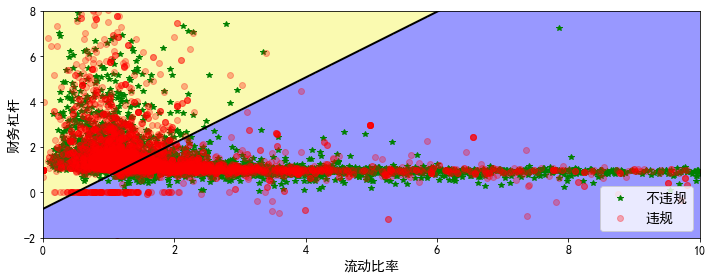

In [7]:
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "g*", label="不违规")
plt.plot(X[y==1, 0], X[y==1, 1], "ro", label="违规",alpha=0.3)

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=2) #画感知机分类线
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("流动比率", fontsize=14)
plt.ylabel("财务杠杆", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_Fraud_plot")
plt.show()

# 激活函数

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

保存图片 activation_functions_plot


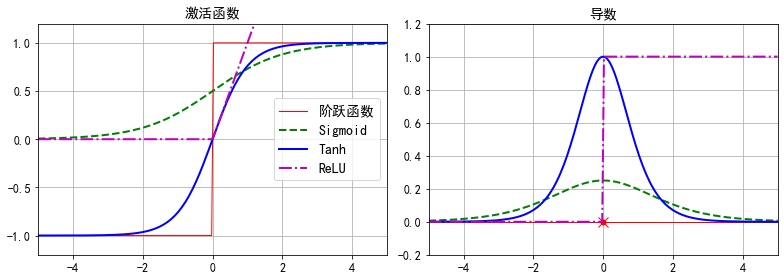

In [9]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="阶跃函数")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("激活函数", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="阶跃函数")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("导数", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

# 基于Keras用神经网络进行财务舞弊识别

Let's load, split and scale the Financial Fraud detection dataset.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
fraud_detection_samples=pd.read_csv("data/fraud_detection_samples.csv",dtype={"股票代码":str})
fraud_detection_samples=fraud_detection_samples.iloc[:,:-2]
fraud_detection_samples=fraud_detection_samples.fillna(0)

In [11]:
fraud_detection_samples.head(1).T

,0
股票代码,601678
截止日期,2010/12/31
行业代码,S90
财务杠杆,1.11611
经营杠杆,1.4499
综合杠杆,1.61824
应收账款与收入比,0.024363
应收账款周转率A,41.0462
存货周转率A,19.9069
营运资金（资本）周转率A,8.82957


In [12]:
X = np.array(fraud_detection_samples.iloc[:,3:-3])
y = np.array(fraud_detection_samples["是否违规"])

chi_square_value, p_value: 271338.84350692213 0.0
kmo value 0.5170820646234289
ev [3.79080241e+00 3.56483164e+00 2.00022217e+00 1.88680572e+00
 1.79629568e+00 1.68660142e+00 1.47429196e+00 1.34322881e+00
 1.22329366e+00 1.09580811e+00 1.08482820e+00 1.06697411e+00
 1.01625838e+00 1.00745336e+00 1.00557410e+00 1.00311717e+00
 1.00060022e+00 9.97565947e-01 9.96556477e-01 9.91875420e-01
 9.69915278e-01 9.45617016e-01 9.29347170e-01 9.19679900e-01
 9.00358816e-01 8.75378263e-01 7.91493255e-01 6.49523542e-01
 5.86169218e-01 5.38869992e-01 4.91850592e-01 4.21329111e-01
 3.56309363e-01 2.93965042e-01 1.86377434e-01 8.10542607e-02
 1.49224778e-02 1.06780838e-02 3.16297880e-03 1.01325460e-03]


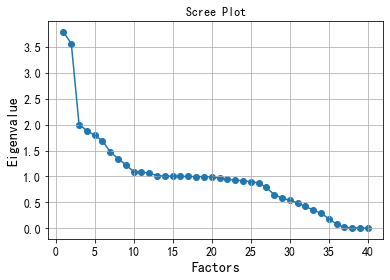

FactorAnalyzer(n_factors=10, rotation='varimax', rotation_kwargs={})

In [13]:
# 使用因子分析法进行降维
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

chi_square_value,p_value=calculate_bartlett_sphericity(X)
print("chi_square_value, p_value:",chi_square_value, p_value)

from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(X)
print("kmo value",kmo_model)
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(40, rotation=None)
fa.fit(X)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
print("ev",ev)

plt.scatter(range(1,X.shape[1]+1),ev)
plt.plot(range(1,X.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

fa = FactorAnalyzer(10, rotation="varimax")
fa.fit(X)
#X=fa.transform(X) 

In [14]:
y.shape

(10641,)

In [15]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X,y, random_state=44)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=44)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)  

In [16]:
X_train_full

array([[1.293344e+00, 1.148923e+00, 1.485953e+00, ..., 5.455220e-01,
        4.441000e+01, 1.000000e+00],
       [1.007881e+00, 1.144692e+00, 1.153713e+00, ..., 4.565110e-01,
        6.939000e+01, 1.000000e+00],
       [9.003940e-01, 2.055421e+00, 1.850688e+00, ..., 1.436600e-01,
        2.681000e+01, 1.000000e+00],
       ...,
       [9.174700e-01, 1.374792e+00, 1.261331e+00, ..., 5.534870e-01,
        7.151000e+01, 1.000000e+00],
       [1.352634e+00, 1.258855e+00, 1.702770e+00, ..., 6.768900e-02,
        2.532000e+01, 1.000000e+00],
       [2.092215e+00, 2.962390e+00, 6.197955e+00, ..., 4.025600e-02,
        4.270000e+01, 3.000000e+00]])

import pandas as pd
pd.DataFrame(X_train).describe()

In [17]:
np.unique(y_train)

array([0, 1], dtype=int64)

In [18]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train.shape[1:]),
    keras.layers.Dense(100, activation="sigmoid"),
    keras.layers.Dense(20, activation="sigmoid"),   
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy",optimizer=keras.optimizers.Adam(learning_rate=1e-3),metrics=['accuracy'])

In [19]:
keras.backend.clear_session()
np.random.seed(44)
tf.random.set_seed(44)

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 100)               4100      
                                                                 
 dense_1 (Dense)             (None, 20)                2020      
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 6,141
Trainable params: 6,141
Non-trainable params: 0
_________________________________________________________________


In [21]:
np.unique(y_train)

array([0, 1], dtype=int64)

In [22]:
X_train.shape

(5985, 40)

In [23]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [24]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2021_12_06-09_14_31'

In [25]:
#history = model.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=300,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb])

Epoch 1/300
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
158/188 [========================>.....] - ETA: 0s - loss: 0.6593 - accuracy: 0.6108WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000002206F141C18> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10

In [26]:
X_new = X_test[:20]

In [27]:
y_test_pred = model.predict(X_new)
y_test_pred=(y_test_pred >0.5).astype(int)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [28]:
y_test_pred.sum()

6

In [29]:
y_test[:20].sum()

9

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

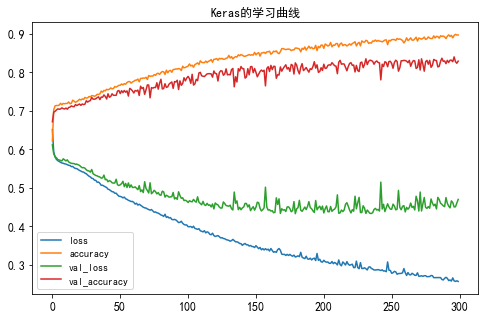

In [31]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
#plt.gca().set_ylim(0, 1)
plt.title("Keras的学习曲线") 
plt.show()
 

In [32]:
mse_test = model.evaluate(X_test, y_test)

84/84 [==============================] - 0s 889us/step - loss: 0.4717 - accuracy: 0.8222


In [33]:
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix
y_test_hat=model.predict(X_test)

AUC is: 0.8799793637544054


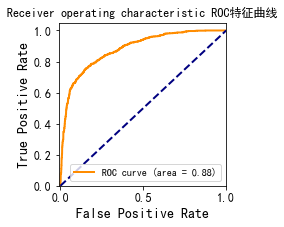

In [34]:
fpr,tpr,threshold = roc_curve(y_test, y_test_hat,drop_intermediate =True)
roc_auc = auc(fpr,tpr)
print("AUC is:",roc_auc)
plt.figure(figsize=(3,3))
plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % roc_auc) #假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ROC特征曲线')
plt.legend(loc="lower right")
plt.show()

Text(32.0, 0.5, 'True label')

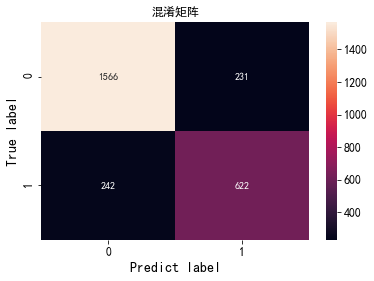

In [35]:
import seaborn as sns
fig,ax=plt.subplots()
y_test_hat=(y_test_hat >0.5).astype(int)

cm = confusion_matrix(y_test, y_test_hat.ravel())

sns.heatmap(cm,annot=True,ax=ax,fmt='d') #画热力图
ax.set_title('混淆矩阵') #标题
ax.set_xlabel('Predict label') #x轴
ax.set_ylabel('True label') #y轴

# 构建图片分类器

In [36]:
import tensorflow as tf
from tensorflow import keras

In [37]:
tf.__version__

'2.7.0'

In [38]:
keras.__version__

'2.7.0'

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [39]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [40]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [41]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set(5000 samples) and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [42]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

In [43]:
np.unique(y_valid)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

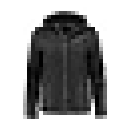

In [44]:
plt.figure(figsize=(2,4))
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [45]:
y_train.shape

(55000,)

Here are the corresponding class names:

In [46]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [47]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [48]:
X_valid.shape

(5000, 28, 28)

In [49]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

保存图片 fashion_mnist_plot


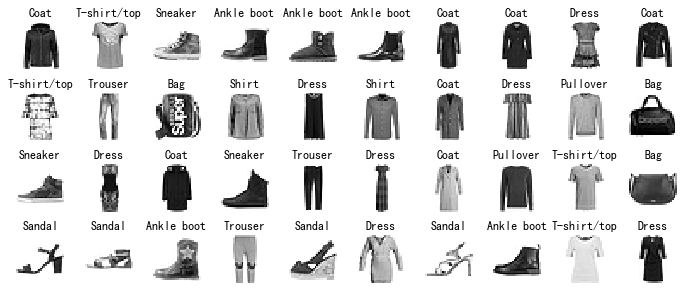

In [50]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [51]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [52]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [53]:
model.layers

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


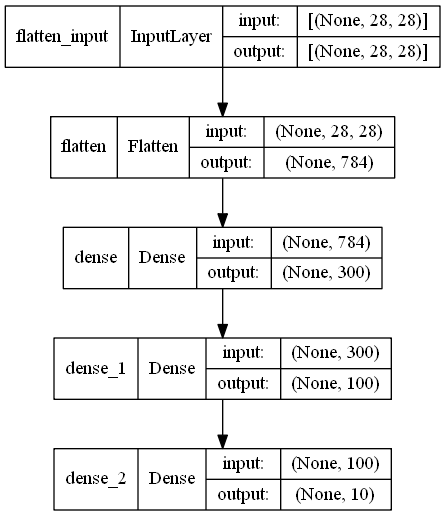

In [55]:
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

In [56]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [57]:
model.get_layer(hidden1.name) is hidden1

True

In [58]:
weights, biases = hidden1.get_weights()

In [59]:
weights.shape

(784, 300)

In [60]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [61]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [62]:
biases.shape

(300,)

In [63]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [64]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1697/1719 [============================>.] - ETA: 0s - loss: 0.7266 - accuracy: 0.7635WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000002207E1C8E58> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=1

In [65]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [66]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [67]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [68]:
np.array(history.history['loss']).shape

(30,)

保存图片 keras_learning_curves_plot


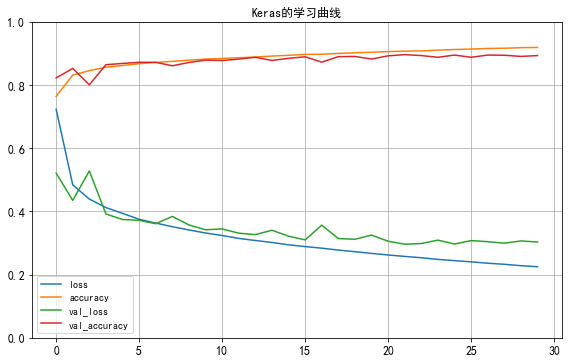

In [69]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.title("Keras的学习曲线")
plt.show()

In [70]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3363 - accuracy: 0.8826


[0.3363315761089325, 0.8826000094413757]

In [71]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.96],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [72]:
#y_pred = model.predict_classes(X_new)
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

array([9, 2, 1], dtype=int64)

In [73]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [74]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

保存图片 fashion_mnist_images_plot


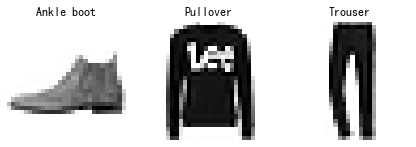

In [75]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# TensorBoard

To start the TensorBoard server, one option is to open a terminal, if needed activate the virtualenv where you installed TensorBoard, go to this notebook's directory, then type:

```bash
$ tensorboard --logdir=./my_logs --port=6006
```

You can then open your web browser to [localhost:6006](http://localhost:6006) and use TensorBoard. Once you are done, press Ctrl-C in the terminal window, this will shutdown the TensorBoard server.

Alternatively, you can load TensorBoard's Jupyter extension and run it like this:

In [84]:
%load_ext tensorboard
%tensorboard --logdir=C:\\Users\\ThinkPad\\Desktop\\AI\\DM_DL\\my_logs 
# --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
